# Immune Peak Count Normalization

**Created**: 6 December 2021

## Environment

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

if (!requireNamespace("Rtsne")) {
    install.packages("Rtsne")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: Rtsne

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)
library(limma)
library(Rtsne)
library(umap)
library(UpSetR)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: limma



## Load Data

In [3]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Lineage, Cell_type, Stimulated, Treatment) %>%
    dplyr::filter(grepl("(Corces|Calderon)", Donor)) %>%
    dplyr::mutate(DA.Treatment=ifelse(Stimulated, "Stimulated", "Baseline")) %>%
    unique() %>%
    dplyr::arrange(Lineage, Cell_type, Treatment, Donor)

rownames(sample.info) <- sample.info$Group.ID

In [4]:
head(sample.info)

,Group.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,DA.Treatment
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,Calderon-1001,B,Bulk_B,FALSE,Control,Baseline
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon-1002,B,Bulk_B,FALSE,Control,Baseline
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon-1003,B,Bulk_B,FALSE,Control,Baseline
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon-1004,B,Bulk_B,FALSE,Control,Baseline
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001,B,Bulk_B,TRUE,Treatment_1,Stimulated
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,Calderon-1002,B,Bulk_B,TRUE,Treatment_1,Stimulated


In [5]:
peak.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) { x[1] })

peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(sample.info$Group.ID))

In [6]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,Calderon-1001-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,⋯,Calderon-1003-Mature_NK-Treatment_1,Calderon-1004-Mature_NK-Treatment_1,Calderon-1008-Mature_NK-Treatment_2,Calderon-1010-Mature_NK-Treatment_2,Calderon-1001-Memory_NK-Control,Calderon-1002-Memory_NK-Control,Calderon-1003-Memory_NK-Control,Calderon-1004-Memory_NK-Control,Calderon-1008-Memory_NK-Control,Calderon-1010-Memory_NK-Control
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:804821-805016,1,804821,805016,+,31,0,6,6,31,⋯,0,5,2,4,0,2,0,0,6,1
1:812642-812879,1,812642,812879,+,0,6,6,4,0,⋯,4,6,3,6,18,5,2,12,10,8
1:815224-815554,1,815224,815554,+,2,4,0,2,0,⋯,6,0,5,12,52,4,0,3,4,8
1:817057-817622,1,817057,817622,+,19,9,2,12,18,⋯,0,8,13,6,56,6,2,34,14,21
1:819712-820327,1,819712,820327,+,33,38,15,64,50,⋯,9,37,43,42,14,30,0,56,39,32
1:821473-823221,1,821473,823221,+,87,105,54,112,101,⋯,34,156,132,148,92,102,6,43,147,139


In [7]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

rownames(tss.enrichment) <- tss.enrichment$Sample

tss.enrichment <- tss.enrichment[sample.info$Group.ID, ]

In [8]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,24.895187
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,4.949709
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,19.412225
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,10.147529
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,26.179913
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,17.425118


## Filter Samples

Filter samples based on their TSS Enrichment Scores. Specifically, remove any samples with TSS Enrichment Scores lower than 6.

In [9]:
good.samples <- tss.enrichment$Sample[tss.enrichment$TSS_Enrichment_Score > 6]

In [10]:
setdiff(tss.enrichment$Sample, good.samples)

[1] "Calderon-1002-Bulk_B-Control"        "Calderon-1002-Memory_Tregs-Control" 
[3] "Calderon-1002-Naive_Teffs-Control"   "Calderon-1008-Naive_Tregs-Control"  
[5] "Calderon-1002-Regulatory_T-Control"  "Calderon-1004-Monocytes-Treatment_1"
[7] "Calderon-1002-Myeloid_DCs-Control"   "Calderon-1008-pDCs-Control"         
[9] "Calderon-1002-Memory_NK-Control"

In [11]:
sample.info <- sample.info[good.samples, ]

In [12]:
peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(good.samples))

In [13]:
tss.enrichment <- tss.enrichment[good.samples, ]

## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [14]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

### Create Sample Groups for Immune Atlas

The Calderon *et al.* and Corces *et al.* studies share cell types. Therefore, they can be analyzed in the same analysis (that is, the design matrix is of the proper rank).

Biological groups will be defined by cell types and stimulation condition.

In [15]:
cell.type <- factor(sample.info$Cell_type)
stimulated <- factor(sample.info$DA.Treatment)
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [16]:
donors <- factor(sample.info$Donor)
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score)

Design matrix for the immune atlas.

In [17]:
design <- model.matrix(~0 + groups + donors + tss.score)

### Create DGEList for Immune Atlas

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [18]:
dge <- DGEList(count.mtx)

Filter peaks using in-built `edgeR` function.

In [19]:
keep <- filterByExpr(dge, design=design, min.count=50, min.total.count=200, min.prop=1)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [20]:
dim(dge)

[1] 261063    169

Calculate normalization factors for the trimmed mean of M-values method.

In [21]:
dge <- calcNormFactors(dge, method="TMM")

### Voom for Immune Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

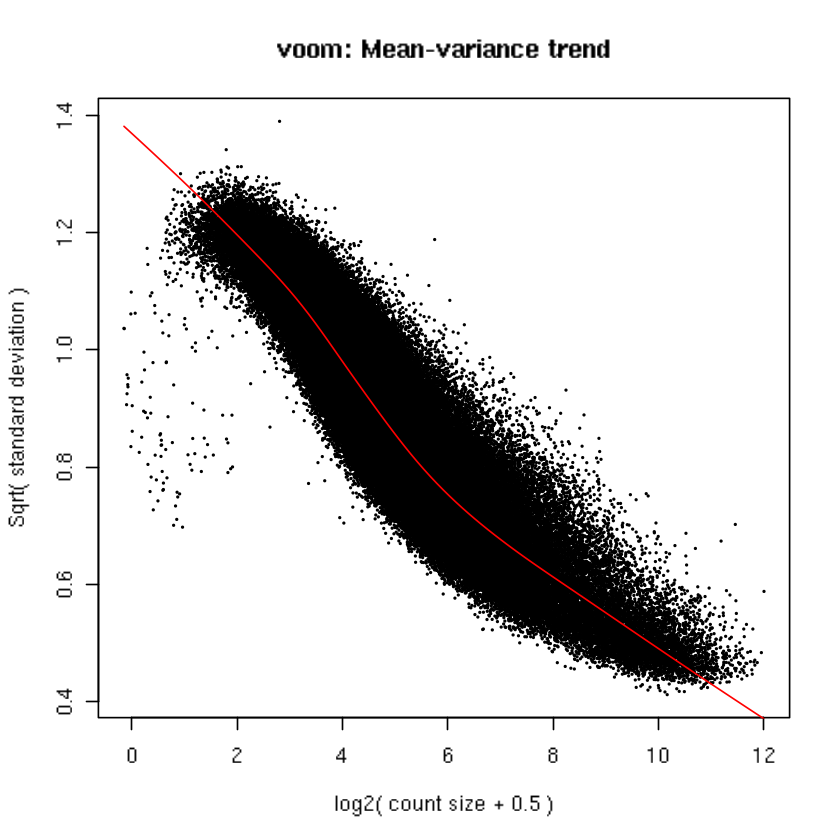

In [22]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [23]:
y.r <- removeBatchEffect(y, batch=donors, covariates=tss.score)

In [24]:
pca <- prcomp(t(as.matrix(y.r)))

In [25]:
control.samples <- sample.info$Group.ID[sample.info$DA.Treatment == "Baseline"]

set.seed(89734987)
tsne.res <- as.matrix(y.r) %>% #[, control.samples] %>%
    t() %>%
    scale() %>%
    Rtsne(., num_threads=15, perplexity=10)

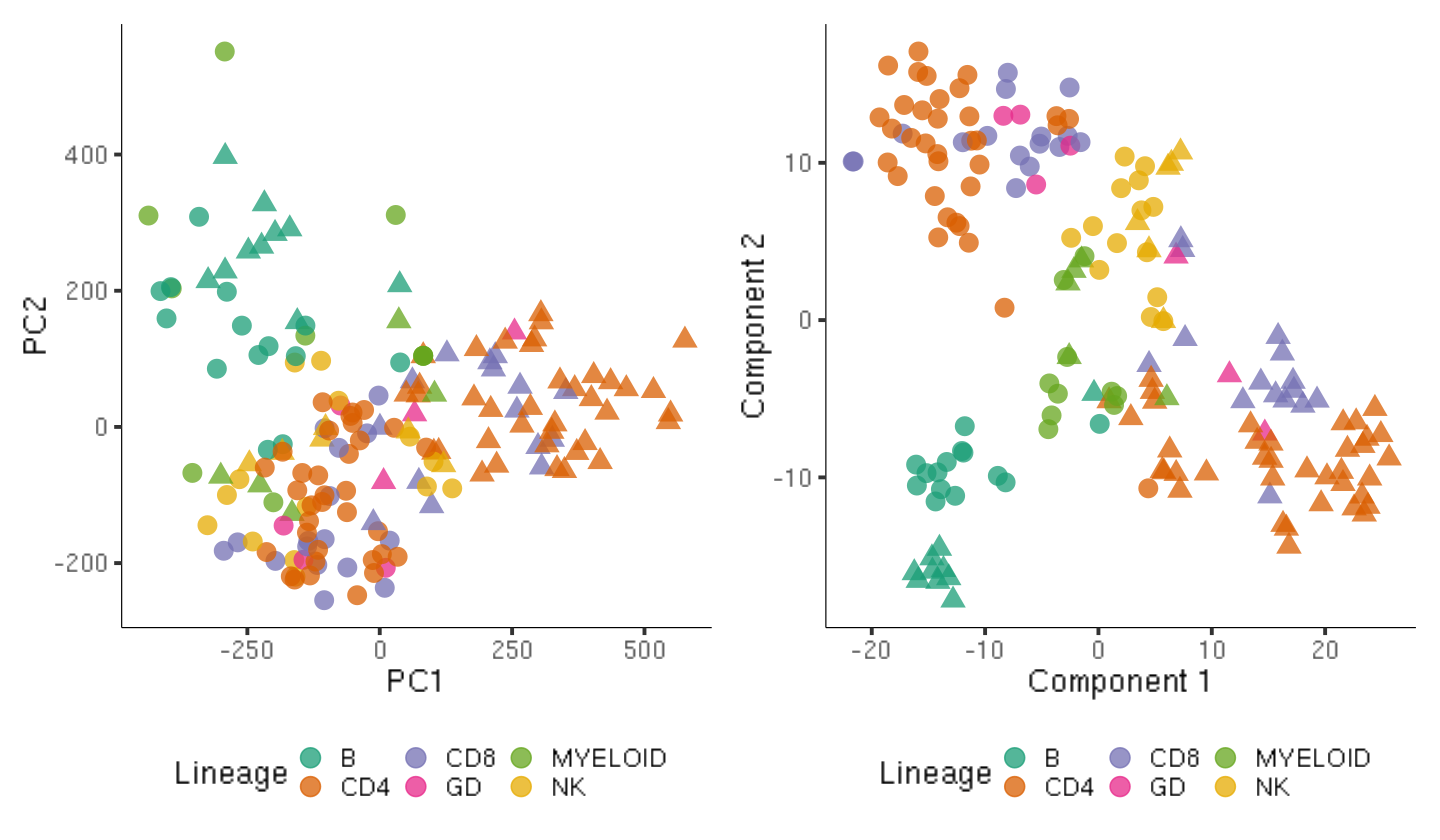

In [26]:
options(repr.plot.width=12, repr.plot.height=7)

p1 <- merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage, shape=Stimulated), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    guides(shape="none") +
    labs(color="Lineage") +
    ggplot_theme

p2 <- tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Sample=colnames(y.r)) %>%
    merge(., sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage, shape=Stimulated), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    guides(shape="none") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

p1 + p2

ggsave("03_Functional_Interpretation/results/immune_normalized_peak_count_pca.pdf", width=12, height=7)

### Limma Fit

Use `limma` to fit a linear model consisting of the biological `groups`.

In [27]:
fit <- lmFit(y, design)

### Limma DA Peaks for Immune Atlas

Identify all cell types where both the baseline and stimulated conditions are present.

In [28]:
cell.type.conditions <- sample.info %>%
    dplyr::select(Cell.Type=Cell_type, DA.Treatment) %>%
    dplyr::group_by(Cell.Type, DA.Treatment) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(DA.Treatment, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [29]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [30]:
da.peaks <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Cell.Type, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

In [31]:
da.peak.set <- da.peaks %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(da.peak.set, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/da_peak_set.csv")

There are 64,020 unique DA peaks.

In [32]:
length(unique(da.peak.set$Peak.ID))

[1] 64020

In [33]:
table(da.peak.set$Cell.Type)


                  Bulk_B                 CD8pos_T  Central_memory_CD8pos_T 
                    1435                     9523                    14464 
       Effector_CD4pos_T Effector_memory_CD8pos_T      Follicular_T_Helper 
                   21081                    16117                    23006 
           Gamma_delta_T                Mature_NK                    Mem_B 
                    5629                      598                     1776 
            Memory_Teffs             Memory_Tregs                Monocytes 
                   32647                     5243                       20 
                 Naive_B              Naive_CD8_T              Naive_Teffs 
                    4722                     2361                    22645 
            Regulatory_T           Th1_precursors          Th17_precursors 
                    9439                    27292                    22922 
          Th2_precursors 
                   23876 

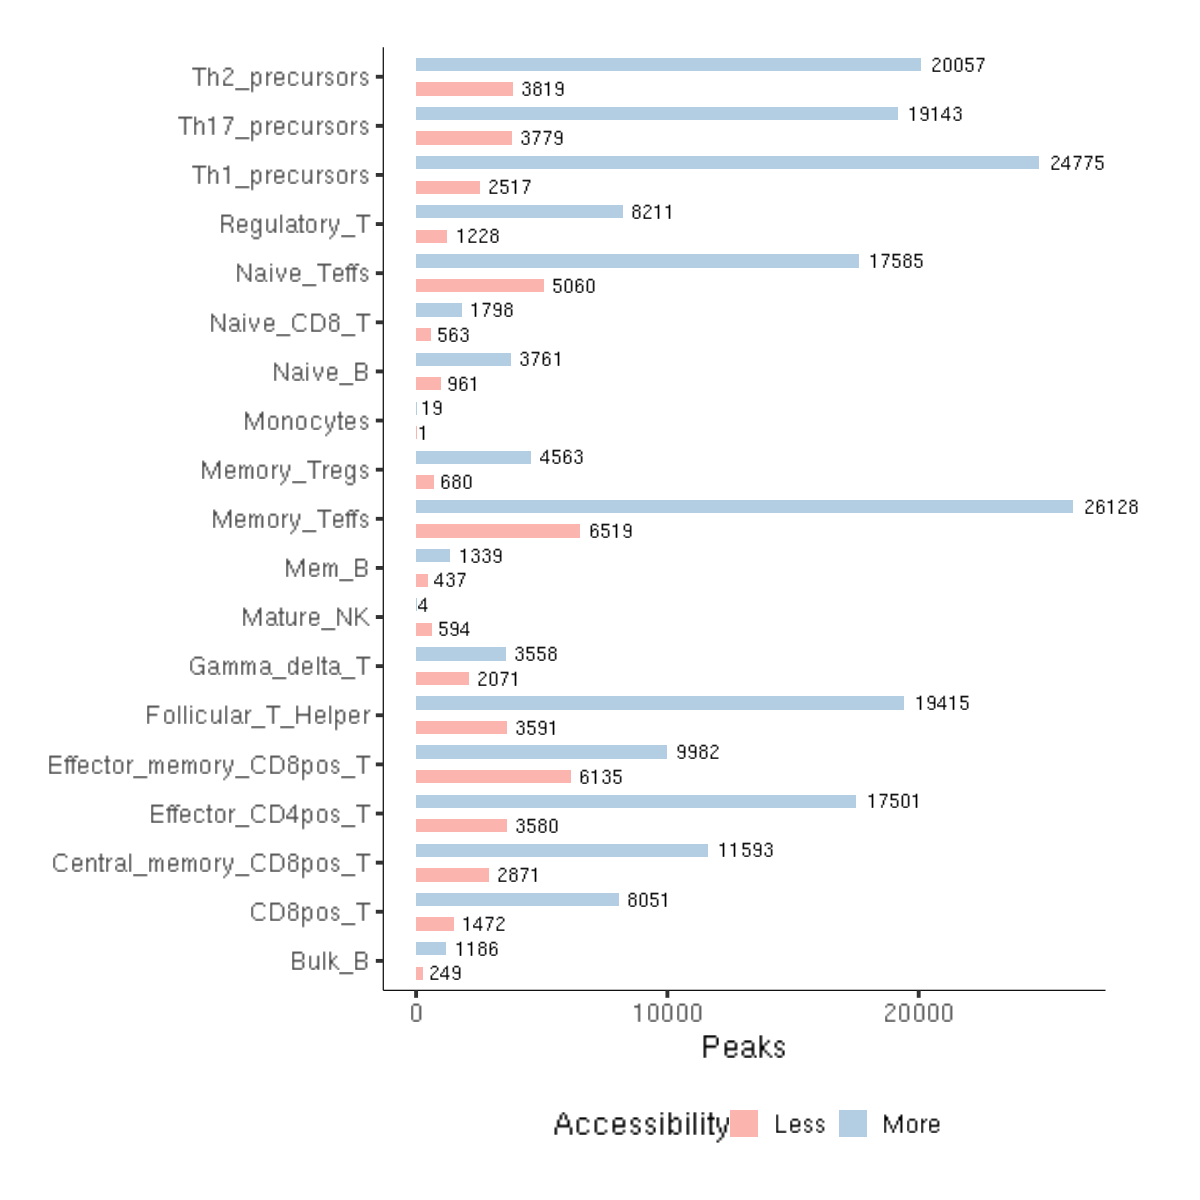

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

da.peak.set %>%
    dplyr::mutate(Accessibility=ifelse(logFC > 1, "More", "Less")) %>%
    dplyr::group_by(Cell.Type, Accessibility) %>%
    dplyr::summarize(Peaks=n(), .groups="drop") %>%
    ggplot() +
    geom_bar(aes(x=Cell.Type, y=Peaks, fill=Accessibility), stat="identity", width=0.5, position=position_dodge(width=1)) +
    geom_text(aes(x=Cell.Type, y=Peaks, label=Peaks, group=Accessibility), hjust=-0.2, vjust=0.5, position=position_dodge(width=1)) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip(clip="off") +
    ggplot_theme +
    theme(axis.title.y.left=element_blank(), plot.margin=margin(1, 2, 1, 1, "cm"))

ggsave("03_Functional_Interpretation/results/immune_da_peak_counts.pdf", width=10, height=10)

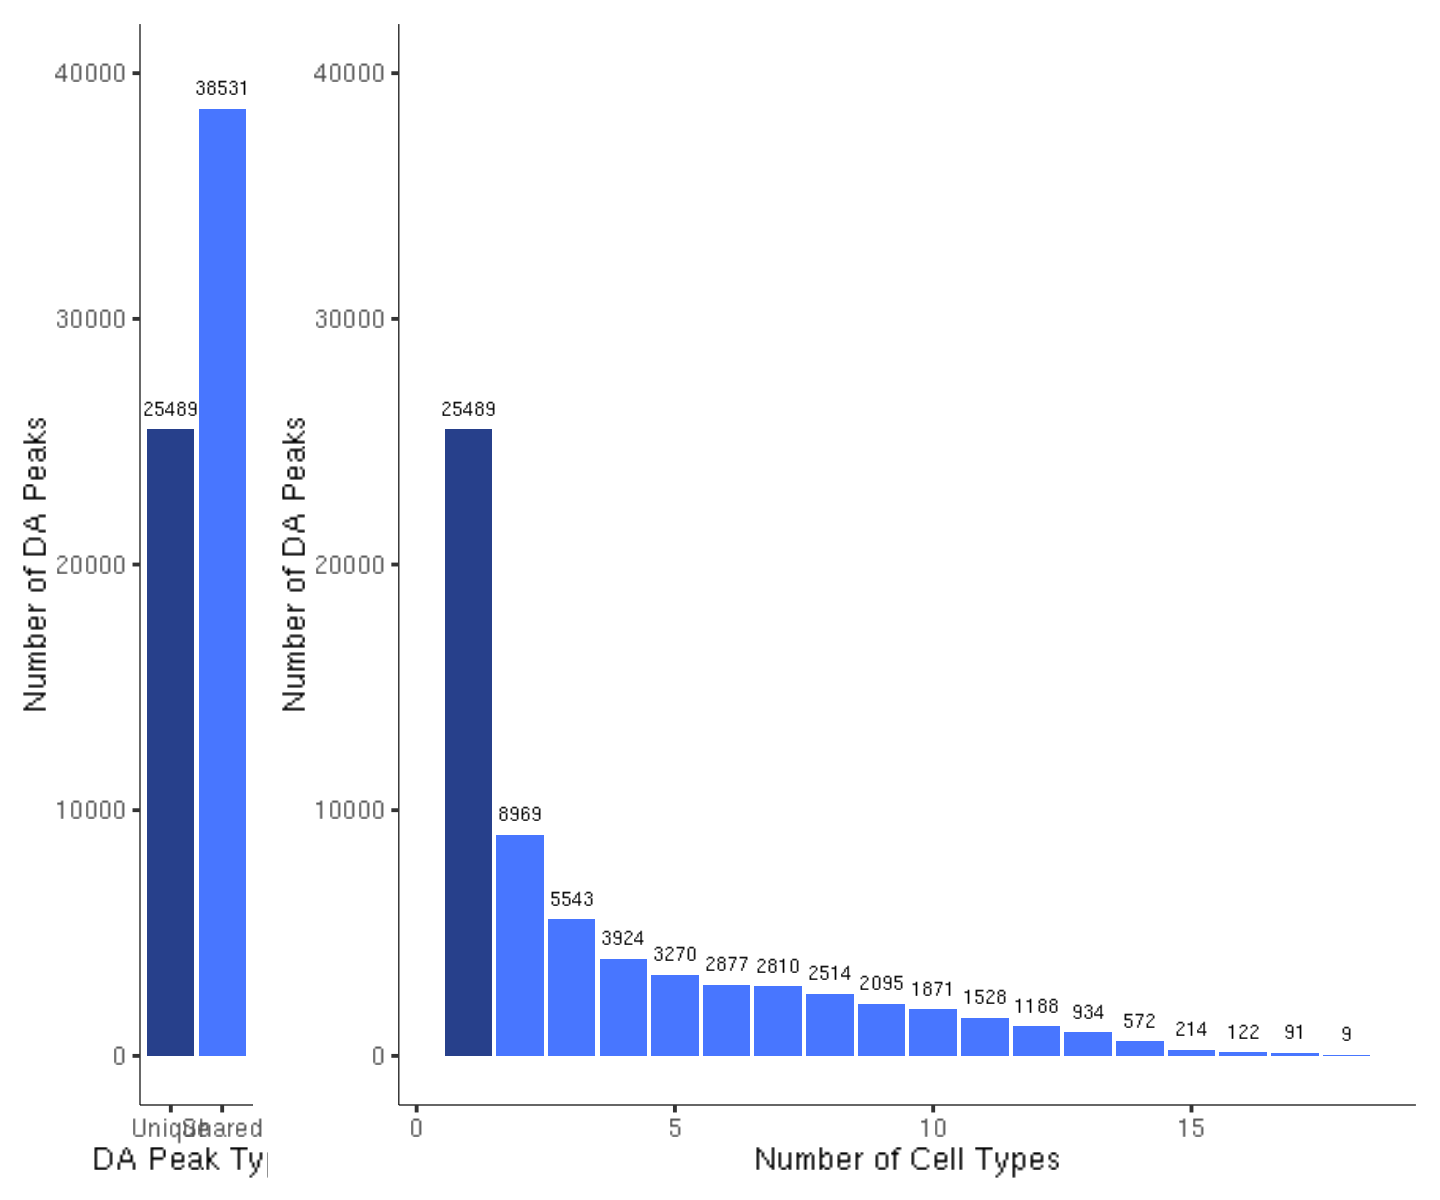

In [36]:
options(repr.plot.width=12, repr.plot.height=10)

p1 <- da.peak.set %>%
    dplyr::count(Peak.ID) %>%
    dplyr::count(n, name="Count") %>%
    dplyr::mutate(Type=factor(ifelse(n == 1, "Unique", "Shared"), levels=c("Unique", "Shared"))) %>%
    ggplot() +
    geom_bar(aes(x=n, y=Count, fill=Type), stat="identity") +
    geom_text(aes(x=n, y=Count, label=Count), vjust=-1) +
    guides(fill="none") +
    scale_fill_manual(values=c("royalblue4", "royalblue1")) +
    xlab("Number of Cell Types") + ylab("Number of DA Peaks") +
    ylim(0, 40000) +
    ggplot_theme

p2 <- da.peak.set %>%
    dplyr::count(Peak.ID) %>%
    dplyr::count(n, name="Count") %>%
    dplyr::mutate(Type=factor(ifelse(n == 1, "Unique", "Shared"), levels=c("Unique", "Shared"))) %>%
    dplyr::group_by(Type) %>%
    dplyr::tally(Count) %>%
    ggplot() +
    geom_bar(aes(x=Type, y=n, fill=Type), stat="identity") +
    geom_text(aes(x=Type, y=n, label=n), vjust=-1) +
    guides(fill="none") +
    scale_fill_manual(values=c("royalblue4", "royalblue1")) +
    xlab("DA Peak Type") + ylab("Number of DA Peaks") +
    ylim(0, 40000) +
    ggplot_theme

p2 + p1 + plot_layout(widths=c(1, 9))

ggsave("03_Functional_Interpretation/results/immune_da_peaks_n_cell_types.pdf", width=12, height=10)

Consistency of direction of effect - 38531 DA peaks are present in more than one cell type. 38078 DA peaks are consistently more accessible or less accessible across cell types. Only 453 are inconsistent.

In [48]:
da.peak.set %>%
    dplyr::mutate(Accessible=ifelse(logFC > 1, "More", "Less")) %>%
    dplyr::count(Peak.ID, Accessible) %>%
    tidyr::spread(Accessible, n, fill=0) %>%
    dplyr::filter(More + Less > 1) %>%
    dplyr::mutate(Both=(More > 0) & (Less > 0)) %>%
    dplyr::count(Both) %>%
    dplyr::mutate(Total = sum(n)) %>%
    dplyr::mutate(Prop = n / Total)

Both,n,Total,Prop
<lgl>,<int>,<int>,<dbl>
FALSE,38078,38531,0.98824323
TRUE,453,38531,0.01175677
